In [1]:
import csv
import numpy as np
import pandas as pd
from PIL import Image
import PIL
import os, sys
import torch
import math
import matplotlib.pyplot as plt
import random
import torchvision
from torch import nn, Tensor
import torch.nn.functional as F
import tqdm

from helper import *

In [2]:
with open('datasets/Diagnosis/DXSUM_PDXCONV_ADNIALL.csv', newline='') as dataset:
    diagnosis = {}
    
    reader = csv.DictReader(dataset, delimiter=",")
    
    for row in reader:
        if row['DXCURREN'] == "3" or row['DIAGNOSIS'] == "3":
            diagnosis[row['PTID']] = "1"
            
        elif row['DXCURREN'] == "1" or row['DIAGNOSIS'] == "1":
            diagnosis[row['PTID']] = "0"

In [3]:
with open('datasets/ADNI_DIAGNOSIS.csv', 'w', newline='\n') as f:
    writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(diagnosis)

In [4]:
data = []

with open('datasets/ADNI_Gene_Expression_Profile.csv', newline='') as dataset:
    reader = csv.reader(dataset, delimiter=",")
    
    while True:
        row = reader.__next__()
            
        if row[0] == "SubjectID":
            data.append(row[3:])
            
            break
            
    while True:
        row = reader.__next__()
            
        if row[0] == "ProbeSet":
            break
    
    for row in reader:
        data.append(row[3:])

In [5]:
sortedData = []

for i in range(len(data[0])):
    rowData = []
    
    for row in data:
        rowData.append(row[i])
        
    sortedData.append(rowData)

In [6]:
data = []

In [7]:
for row in sortedData:
    try:
        row[0] = diagnosis[row[0]]
        
        data.append(row)
    except:
        pass

In [8]:
data = toFloat(data)

In [9]:
data = normalize(data)
data = normalizeRow(data)
data = normalize(data)

random.shuffle(data)

nnTrain = len(data) - int(len(data) * 0.2)

In [10]:
print(nnTrain)

259


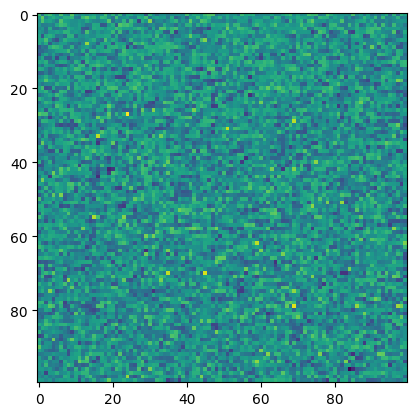

In [11]:
import matplotlib.pyplot as plt

plt.imshow(torch.Tensor(data[1][1:10001]).view(100, 100))

In [12]:
ad = 0
ctl = 0

for i in range(len(data)):
    if data[i][0] == "1":
        ad += 1
    else:
        ctl += 1

In [13]:
def flip(n):
    if n == 0.0:
        return 1.0
    
    else:
        return 0.0

In [14]:
print(ad)
print(ctl)

101
222


In [15]:
train = data[:nnTrain]
test = data[nnTrain:]

In [16]:
rValues = getRValues(train, test, ctl, ad)

In [17]:
FINAL_LEN = 1024
BLOCK_SIZE = 64
DATA_LEN = 4096

NOISE = 20

TRAIN_LEN = NOISE * nnTrain
TOTAL_LEN = TRAIN_LEN + len(data) - nnTrain

repeats = math.ceil(FINAL_LEN / (DATA_LEN / BLOCK_SIZE))

In [18]:
del rValues[DATA_LEN:]

In [19]:
processAll(repeats, rValues, DATA_LEN, BLOCK_SIZE, NOISE, train, test)

In [20]:
if BLOCK_SIZE == 1:
    fullTrain = []
    fullTest = []

    for i in range(len(train)):
        rowData = []

        for j in range(len(rValues)):
            rowData.append(train[i][rValues[j][0] + 1])

        rowData.insert(0, float(train[i][0]))
        fullTrain.append(rowData)
        
    
    for x in range(NOISE - 1):
        for i in range(len(train)):
            rowData = []

            for j in range(len(rValues)):
                a = np.random.normal(loc=0, scale=0.01)
                rowData.append(train[i][rValues[j][0] + 1] + a)

            rowData.insert(0, float(train[i][0]))
            fullTrain.append(rowData)


    for i in range(len(test)):
        rowData = []

        for j in range(len(rValues)):
            rowData.append(test[i][rValues[j][0] + 1])

        rowData.insert(0, float(test[i][0]))
        fullTest.append(rowData)
    
    with open('datasets/train_adni.csv', 'w') as f:
        writer = csv.writer(f, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerows(fullTrain)
    
    with open('datasets/test_adni.csv', 'w') as f:
        writer = csv.writer(f, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerows(fullTest)
    
    exit(0)

In [21]:
print(len(rowData))

49387


In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

headers = ['labels'] + list(range(BLOCK_SIZE))

train = pd.read_csv('datasets/train_full/0.csv', names=headers)
test = pd.read_csv('datasets/test_full/0.csv', names=headers)

y_train = train["labels"]
y_test = test["labels"]

LDAtrain = [list(y_train)]
LDAtest = [list(y_test)]

if NOISE > 1:
    noise = pd.read_csv('datasets/noise_full/0.csv', names=headers)
    y_noise = noise["labels"]
    LDAnoise = [list(y_noise)]

for i in tqdm.notebook.tqdm(range(FINAL_LEN)):
    train = pd.read_csv(f'datasets/train_full/{i}.csv', names=headers)
    test = pd.read_csv(f'datasets/test_full/{i}.csv', names=headers)
    
    if NOISE > 1:
        noise = pd.read_csv(f'datasets/noise_full/{i}.csv', names=headers)
        
        X_noise = noise.drop(["labels"], axis=1)
        y_noise = noise["labels"]
    
    X_train = train.drop(["labels"], axis=1)
    y_train = train["labels"]
    
    X_test = test.drop(["labels"], axis=1)
    y_test = test["labels"]
    
    model = LinearDiscriminantAnalysis(n_components=1)
    
    X_train_lda = model.fit_transform(X_train, y_train)
    X_test_lda = model.transform(X_test)
    
    LDAtrain.append(X_train_lda)
    LDAtest.append(X_test_lda)
    
    if NOISE > 1:
        X_noise_lda = model.transform(X_noise)
        LDAnoise.append(X_noise_lda)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [23]:
print(len(LDAtrain), len(y_train))

1025 259


In [38]:
train = []
test = []
noise = []

In [39]:
for i in range(len(LDAtrain[0])):
    rowData = []

    for row in LDAtrain:
        rowData.append(float(row[i]))
        
    train.append(rowData)

In [40]:
for i in range(len(LDAtest[0])):
    rowData = []

    for row in LDAtest:
        rowData.append(float(row[i]))
        
    test.append(rowData)

In [41]:
if NOISE > 1:
    for i in range(len(LDAnoise[0])):
        rowData = []

        for row in LDAnoise:
            rowData.append(float(row[i]))

        noise.append(rowData)

In [42]:
rValues = getRValues(train, test, ctl, ad)

del rValues[FINAL_LEN:]

sortedTrain = []
sortedTest = []
sortedNoise = []

for i in range(len(train)):
    rowData = []

    for j in range(len(rValues)):
        rowData.append(train[i][rValues[j][0] + 1])

    rowData.insert(0, float(train[i][0]))
    sortedTrain.append(rowData)


for i in range(len(test)):
    rowData = []

    for j in range(len(rValues)):
        rowData.append(test[i][rValues[j][0] + 1])

    rowData.insert(0, float(test[i][0]))
    sortedTest.append(rowData)

if NOISE > 1:
    for i in range(len(noise)):
        rowData = []

        for j in range(len(rValues)):
            rowData.append(noise[i][rValues[j][0] + 1])

        rowData.insert(0, float(noise[i][0]))
        sortedNoise.append(rowData)

In [43]:
if NOISE > 1:
    data = sortedTrain + sortedNoise + sortedTest
    
else:
    data = sortedTrain + sortedTest

data = normalize(data)

sortedTrain = data[:TRAIN_LEN]
sortedTest = data[TRAIN_LEN:]

In [44]:
# train2 = sortedTrain.copy()

# for i in range(len(train2[0])):
#     flipCol(train2, i)
    
# sortedTrain = sortedTrain + train2

In [45]:
print(len(sortedTest))
print(len(sortedTrain))

print(len(sortedTrain[0]))
print(len(sortedTest[0]))

64
10360
1025
1025


In [46]:
with open('datasets/train_adni.csv', 'w') as f:
    writer = csv.writer(f, quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(sortedTrain)
    
with open('datasets/test_adni.csv', 'w') as f:
    writer = csv.writer(f, quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(sortedTest)